# Lab 6: Build A Course Recommendation System 

The goal of this assignment is to get familier with basic methods in recommender systems.

The dataset is a paper titled "Understanding Dropouts in MOOCs", the dataset was once used as a data competition source for KDD conference, thus some solution ideas can be accessed for your reference.

The dataset can be accessed and downloaded via: http://moocdata.cn/data/user-activity 

There are multiple dataset provided by the authors, you can use KDDCUP 15 or their more recent user-course interaction data.

Recommended tutorials: 

https://towardsdatascience.com/a-complete-guide-to-recommender-system-tutorial-with-sklearn-surprise-keras-recommender-5e52e8ceace1

https://colab.research.google.com/drive/1w92d6_BjrF5nVLoFhD1Oa6dV3DgKra8G?usp=sharing 

https://www.youtube.com/watch?v=eRACsfAlPic 

**Submission: submit via onq.** 


In [1]:
# Import needed libraries. 
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import missingno
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

In [2]:
def check_missing(df):
    if df.isna().values.any() == True:
    #this condidtion will be evaluated.
        print("There are missing values in this dataframe")
    else:
        print("There aren't any missing values in this dataframe")
    total_miss = df.isnull().sum()
    percent_miss = (total_miss/df.isnull().count()*100)

    # sort attributes by missing value ratio
    missing_data = pd.DataFrame({'Total missing':total_miss,'% missing':percent_miss})
    missing_data.sort_values(by='Total missing',ascending=False)
    missingno.bar(df)
    missingno.matrix(df)
    return missing_data

In [3]:
def check_duplicates(df):
    if df.duplicated().any()== True:
        print("There are duplicated values in this dataset.")
    else:
        print("There aren't duplicated values in this dataset")

    print(f"There are {df.duplicated().sum()} consistent duplicated values in this dataset.")
    print(df[df.duplicated()].head(20))

## Task 1: Download Dataset, Data Exploration and Preprocessing

There are several data provided under this task. Please carefully read them and briefly report their relationship. 

Perform basic dataset exploration and report the statistic of the dataset and quality of the dataset. Perform data preprocessing if needed. 

# TODO textual answer for task 1

### Read train dataset

In [4]:
# TODO code for task 1
truth_train = pd.read_csv("C:\\Users\\Zeyad Tarek\\Documents\\lab 6 da\\train\\truth_train.csv", names=['enrollment_id','course_compilation'])
log_train = pd.read_csv("C:\\Users\\Zeyad Tarek\\Documents\\lab 6 da\\train\\log_train.csv")
enrollment_train = pd.read_csv("C:\\Users\\Zeyad Tarek\\Documents\\lab 6 da\\train\\enrollment_train.csv")

In [5]:
print(f"truth train has {truth_train.shape[0]} samples and {truth_train.shape[1]} features and the features are {truth_train.columns}.")
print(f"log train has {log_train.shape[0]} samples and {log_train.shape[1]} features and the features are {log_train.columns}.")
print(f"enrollment train has {enrollment_train.shape[0]} samples and {enrollment_train.shape[1]} features and the features are {enrollment_train.columns}.")

truth train has 120542 samples and 2 features and the features are Index(['enrollment_id', 'course_compilation'], dtype='object').
log train has 8157277 samples and 5 features and the features are Index(['enrollment_id', 'time', 'source', 'event', 'object'], dtype='object').
enrollment train has 120542 samples and 3 features and the features are Index(['enrollment_id', 'username', 'course_id'], dtype='object').


### Read test dataset

In [6]:
truth_test = pd.read_csv("C:\\Users\\Zeyad Tarek\\Documents\\lab 6 da\\test\\truth_test.csv", names=['enrollment_id','course_compilation'])
log_test = pd.read_csv("C:\\Users\\Zeyad Tarek\\Documents\\lab 6 da\\test\\log_test.csv")
enrollment_test = pd.read_csv("C:\\Users\\Zeyad Tarek\\Documents\\lab 6 da\\test\\enrollment_test.csv")

In [7]:
print(f"truth test has {truth_test.shape[0]} samples and {truth_test.shape[1]} features and the features are {truth_test.columns}.")
print(f"log test has {log_test.shape[0]} samples and {log_test.shape[1]} features and the features are {log_test.columns}.")
print(f"enrollment test has {enrollment_test.shape[0]} samples and {enrollment_test.shape[1]} features and the features are {enrollment_test.columns}.")

truth test has 80362 samples and 2 features and the features are Index(['enrollment_id', 'course_compilation'], dtype='object').
log test has 5387847 samples and 5 features and the features are Index(['enrollment_id', 'time', 'source', 'event', 'object'], dtype='object').
enrollment test has 80362 samples and 3 features and the features are Index(['enrollment_id', 'username', 'course_id'], dtype='object').


For this recommendation system, I decided to use the most three important datasets, which will make me to build a reasonable recommendation system.

<table>
  <thead>
    <tr>
      <th>Information</th>
      <th>Information</th>
    </tr>
   </thead>
   <tbody>
     <tr>
       <td>Enrolment</td>
       <td> Registered learners.</td>
     </tr>
     <tr>
       <td>Log (main dataset)</td>
       <td>Keeping track of one's behavior.</td>
     </tr>
       <td>Truth</td>
       <td>Completion or dropout rate of learners.</td>
     </tr>
     <tr>
     </tr>
  </tbody>
</table>

All the three datasets have a commen feature which is enrollment ID, I will join three dataset based on this feature to leverge from the information in all three datasets.

### Join three train datasets based on enrollment_id values

In [8]:
train_dataset  = pd.merge(enrollment_train,truth_train, on=['enrollment_id'])
train_dataset = pd.merge(log_train, train_dataset, on = ['enrollment_id'])

In [9]:
train_dataset.info()
train_dataset.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8157277 entries, 0 to 8157276
Data columns (total 8 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   enrollment_id       int64 
 1   time                object
 2   source              object
 3   event               object
 4   object              object
 5   username            object
 6   course_id           object
 7   course_compilation  int64 
dtypes: int64(2), object(6)
memory usage: 560.1+ MB


,enrollment_id,course_compilation
count,8.157277e+06,8.157277e+06
mean,6.347631e+04,3.974209e-01
std,5.185092e+04,4.893644e-01
min,1.000000e+00,0.000000e+00
25%,1.872100e+04,0.000000e+00
50%,4.833100e+04,0.000000e+00
75%,1.103750e+05,1.000000e+00
max,2.009050e+05,1.000000e+00


In [10]:
train_dataset.head()

,enrollment_id,time,source,event,object,username,course_id,course_compilation
0,1,2014-06-14T09:38:29,server,navigate,Oj6eQgzrdqBMlaCtaq1IkY6zruSrb71b,9Uee7oEuuMmgPx2IzPfFkWgkHZyPbWr0,DPnLzkJJqOOPRJfBxIHbQEERiYHu5ila,0
1,1,2014-06-14T09:38:39,server,access,3T6XwoiMKgol57cm29Rjy8FXVFcIomxl,9Uee7oEuuMmgPx2IzPfFkWgkHZyPbWr0,DPnLzkJJqOOPRJfBxIHbQEERiYHu5ila,0
2,1,2014-06-14T09:38:39,server,access,qxvBNYTfiRkNcCvM0hcGwG6hvHdQwnd4,9Uee7oEuuMmgPx2IzPfFkWgkHZyPbWr0,DPnLzkJJqOOPRJfBxIHbQEERiYHu5ila,0
3,1,2014-06-14T09:38:48,server,access,2cmZrZW2h6Il91itO3e89FGcABLWhf3W,9Uee7oEuuMmgPx2IzPfFkWgkHZyPbWr0,DPnLzkJJqOOPRJfBxIHbQEERiYHu5ila,0
4,1,2014-06-14T09:41:49,browser,problem,RMtgC2bTAqEeftenUUyia504wsyzeZWf,9Uee7oEuuMmgPx2IzPfFkWgkHZyPbWr0,DPnLzkJJqOOPRJfBxIHbQEERiYHu5ila,0


### Join three test datasets based on enrollment_id values

In [11]:
test_dataset  = pd.merge(enrollment_test,truth_test, on=['enrollment_id'])
test_dataset = pd.merge(log_test, test_dataset, on = ['enrollment_id'])

In [12]:
test_dataset.info()
test_dataset.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5387847 entries, 0 to 5387846
Data columns (total 8 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   enrollment_id       int64 
 1   time                object
 2   source              object
 3   event               object
 4   object              object
 5   username            object
 6   course_id           object
 7   course_compilation  int64 
dtypes: int64(2), object(6)
memory usage: 370.0+ MB


,enrollment_id,course_compilation
count,5.387847e+06,5.387847e+06
mean,6.417259e+04,4.006216e-01
std,5.213314e+04,4.900245e-01
min,2.000000e+00,0.000000e+00
25%,1.893400e+04,0.000000e+00
50%,4.863000e+04,0.000000e+00
75%,1.112150e+05,1.000000e+00
max,2.009030e+05,1.000000e+00


In [13]:
test_dataset.head()

,enrollment_id,time,source,event,object,username,course_id,course_compilation
0,2,2014-06-13T09:52:49,server,navigate,Oj6eQgzrdqBMlaCtaq1IkY6zruSrb71b,iK5aDr3NHFx1sykGJ4dWSgjjEPGK9DAb,DPnLzkJJqOOPRJfBxIHbQEERiYHu5ila,0
1,2,2014-06-13T09:58:09,server,access,3T6XwoiMKgol57cm29Rjy8FXVFcIomxl,iK5aDr3NHFx1sykGJ4dWSgjjEPGK9DAb,DPnLzkJJqOOPRJfBxIHbQEERiYHu5ila,0
2,2,2014-06-13T09:58:09,server,access,qxvBNYTfiRkNcCvM0hcGwG6hvHdQwnd4,iK5aDr3NHFx1sykGJ4dWSgjjEPGK9DAb,DPnLzkJJqOOPRJfBxIHbQEERiYHu5ila,0
3,2,2014-06-13T09:58:26,browser,access,qxvBNYTfiRkNcCvM0hcGwG6hvHdQwnd4,iK5aDr3NHFx1sykGJ4dWSgjjEPGK9DAb,DPnLzkJJqOOPRJfBxIHbQEERiYHu5ila,0
4,2,2014-06-13T09:58:27,browser,access,qxvBNYTfiRkNcCvM0hcGwG6hvHdQwnd4,iK5aDr3NHFx1sykGJ4dWSgjjEPGK9DAb,DPnLzkJJqOOPRJfBxIHbQEERiYHu5ila,0


### duplicated check for train dataset

In [14]:
check_duplicates(train_dataset)

There are duplicated values in this dataset.
There are 343701 consistent duplicated values in this dataset.
     enrollment_id                 time   source    event  \
83               1  2014-06-27T01:10:52  browser  problem   
111              1  2014-06-27T01:21:31  browser  problem   
244              1  2014-07-04T07:35:49  browser  problem   
251              1  2014-07-04T07:48:41  browser  problem   
275              1  2014-07-11T08:43:48  browser  problem   
292              1  2014-07-11T09:14:29  browser  problem   
311              1  2014-07-11T09:32:28  browser  problem   
325              3  2014-06-19T08:45:05  browser  problem   
329              3  2014-06-19T08:45:12  browser  problem   
334              3  2014-06-19T08:45:42  browser  problem   
336              3  2014-06-19T08:45:52  browser  problem   
339              3  2014-06-19T08:46:07  browser  problem   
352              3  2014-06-26T06:17:17  browser  problem   
354              3  2014-06-26T06:17:4

### duplicated check for test dataset

In [15]:
check_duplicates(test_dataset)

There are duplicated values in this dataset.
There are 224024 consistent duplicated values in this dataset.
     enrollment_id                 time   source       event  \
5                2  2014-06-13T09:58:27  browser      access   
18               2  2014-06-13T10:00:01   server  discussion   
26               2  2014-06-13T10:00:25   server        wiki   
66               2  2014-06-13T10:10:42   server      access   
86               2  2014-06-13T10:36:26   server      access   
160              2  2014-06-13T11:46:06   server  discussion   
206              2  2014-06-13T12:07:49  browser      access   
475              2  2014-06-20T07:07:41   server      access   
512              2  2014-06-20T09:27:41   server      access   
544              2  2014-06-20T10:31:55   server      access   
554              2  2014-06-20T10:58:21   server      access   
563              2  2014-06-20T22:49:47   server    navigate   
608              2  2014-06-20T23:13:30   server      access

### missing values check for train dataset

There aren't any missing values in this dataframe


,Total missing,% missing
enrollment_id,0,0.0
time,0,0.0
source,0,0.0
event,0,0.0
object,0,0.0
username,0,0.0
course_id,0,0.0
course_compilation,0,0.0


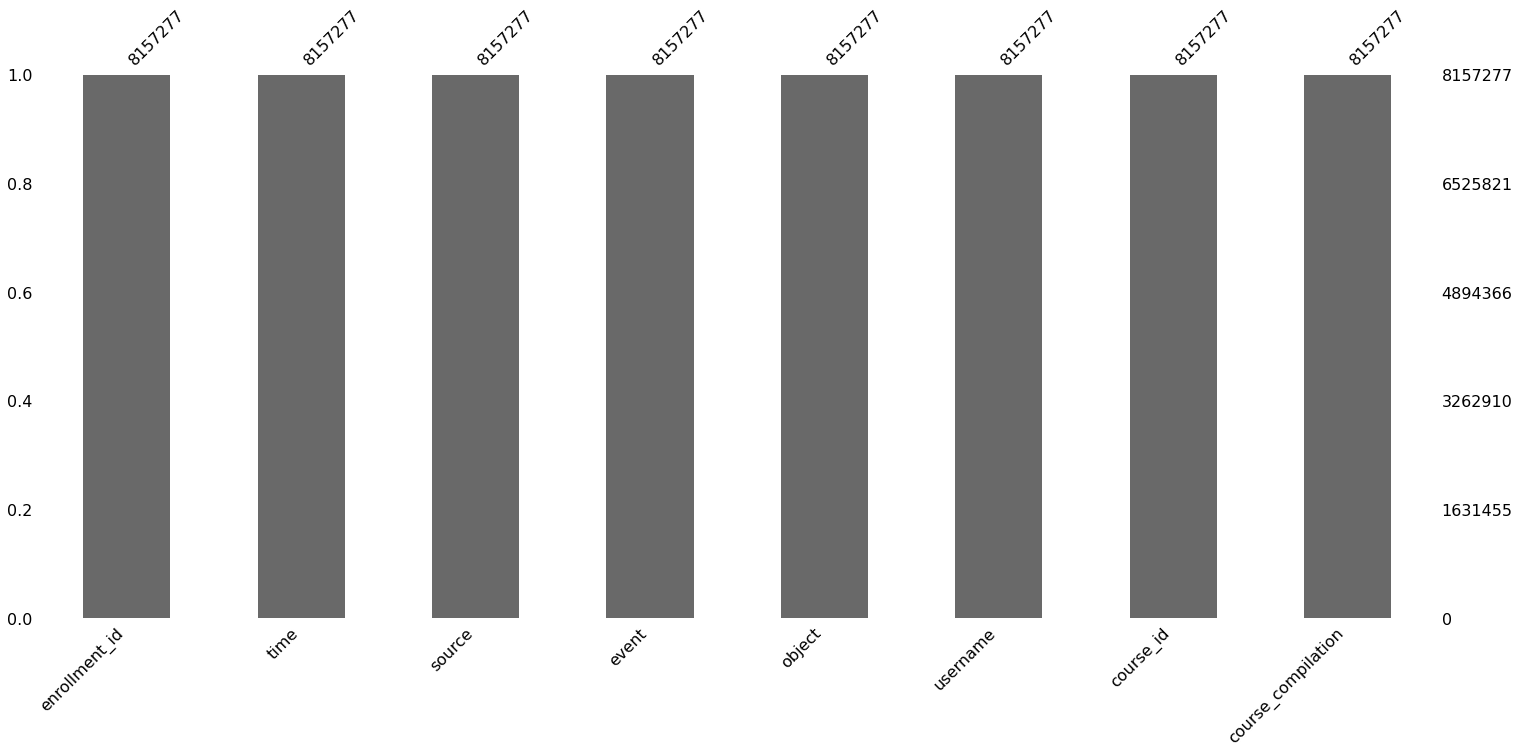

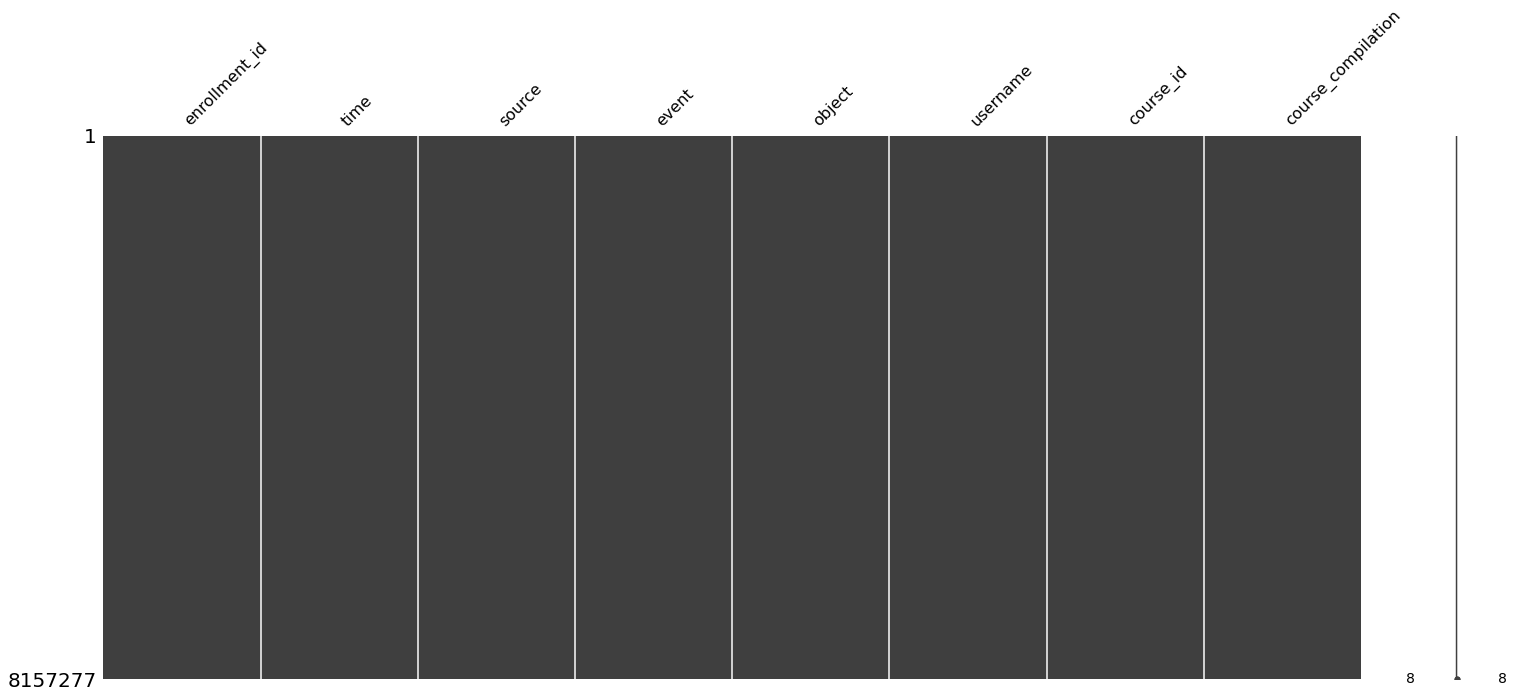

In [16]:
train_missings = check_missing(train_dataset)
train_missings

### missing values check for test dataset

There aren't any missing values in this dataframe


,Total missing,% missing
enrollment_id,0,0.0
time,0,0.0
source,0,0.0
event,0,0.0
object,0,0.0
username,0,0.0
course_id,0,0.0
course_compilation,0,0.0


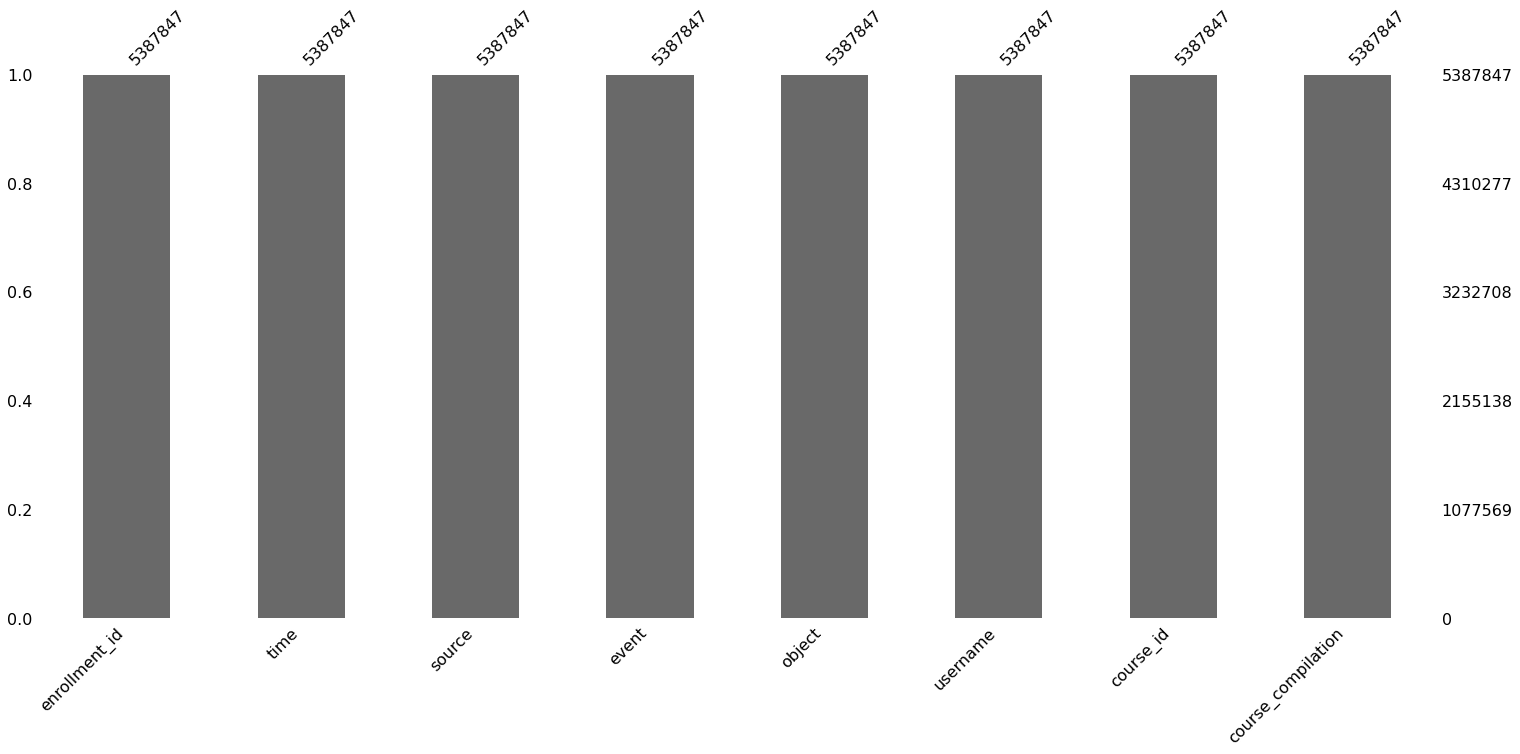

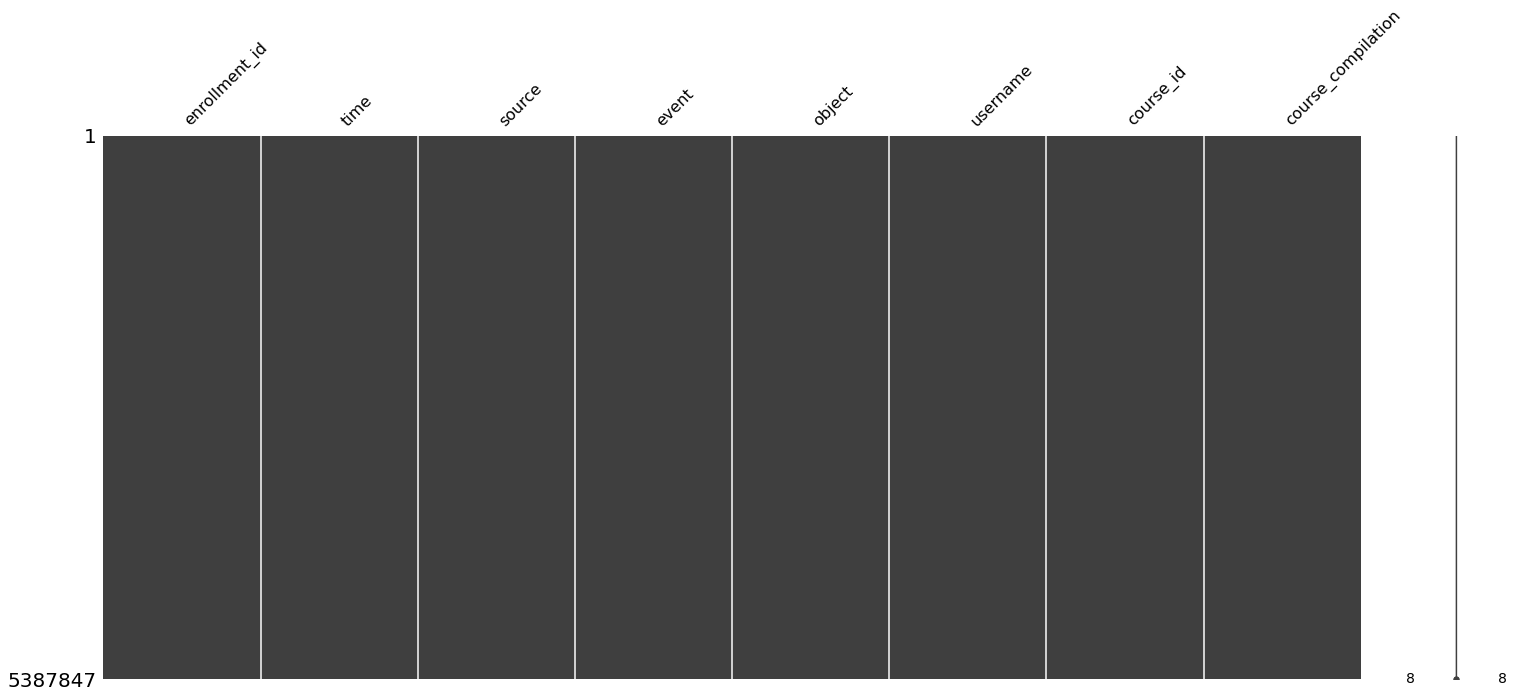

In [17]:
test_missings = check_missing(test_dataset)
test_missings

### drop duplicated values from training dataset

In [18]:
train_dataset = train_dataset.drop_duplicates()

### drop duplicated values from testing dataset

In [19]:
test_dataset = test_dataset.drop_duplicates()

### Basic data exploration before feature engineering process

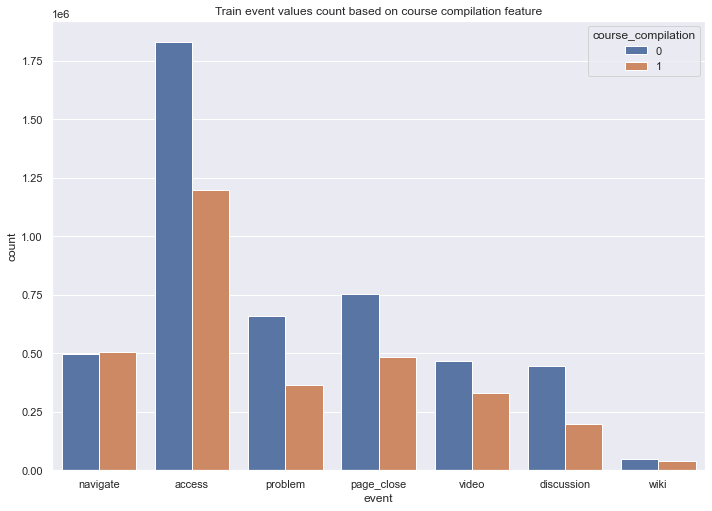

In [20]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
test_event_count = sns.countplot(x="event",hue="course_compilation", data=train_dataset)
test_event_count.set(title = "Train event values count based on course compilation feature")
plt.show()

<AxesSubplot:ylabel='event'>

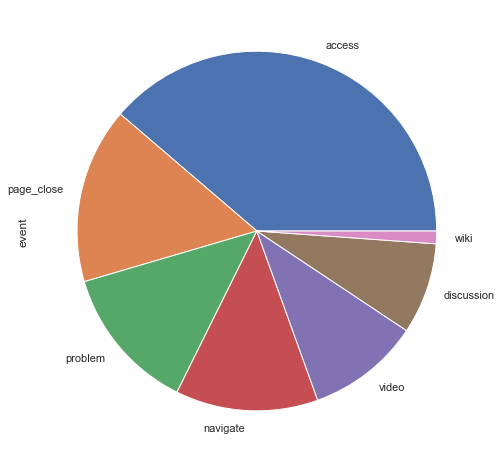

In [21]:
train_dataset['event'].value_counts().plot.pie()

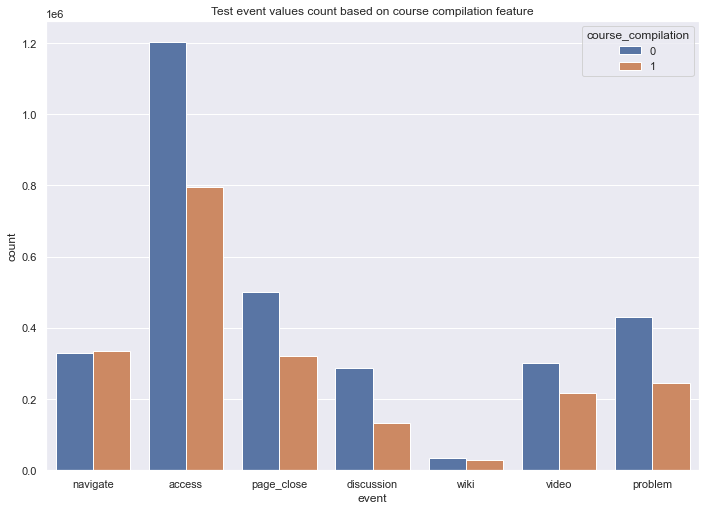

In [22]:
test_event_count = sns.countplot(x="event",hue="course_compilation", data=test_dataset)
test_event_count.set(title = "Test event values count based on course compilation feature")
plt.show()

<AxesSubplot:ylabel='event'>

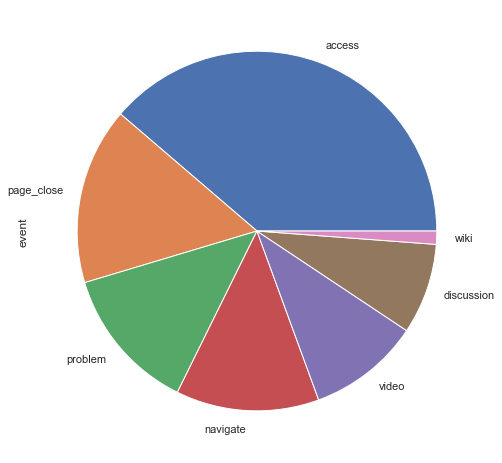

In [23]:
test_dataset['event'].value_counts().plot.pie()

<AxesSubplot:xlabel='source', ylabel='count'>

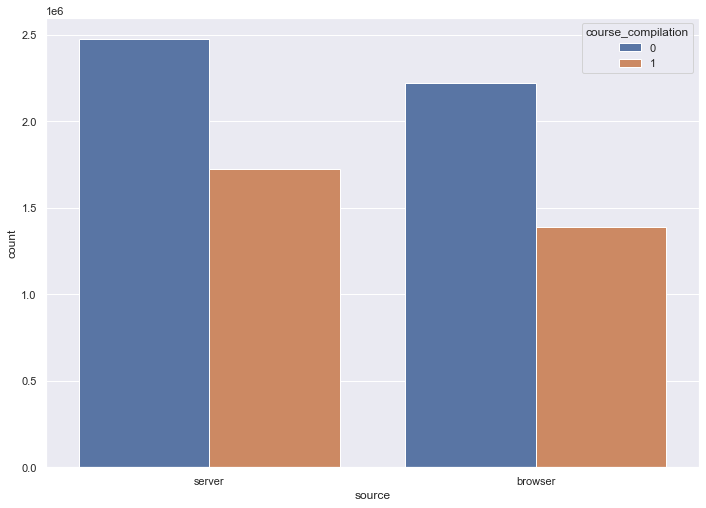

In [24]:
sns.countplot(x="source",hue="course_compilation", data=train_dataset)

<AxesSubplot:xlabel='source', ylabel='count'>

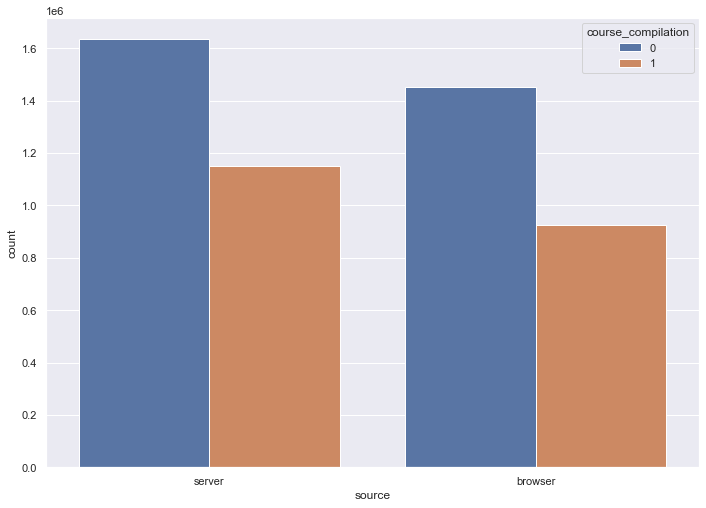

In [25]:
sns.countplot(x="source",hue="course_compilation", data=test_dataset)

<AxesSubplot:xlabel='course_compilation', ylabel='count'>

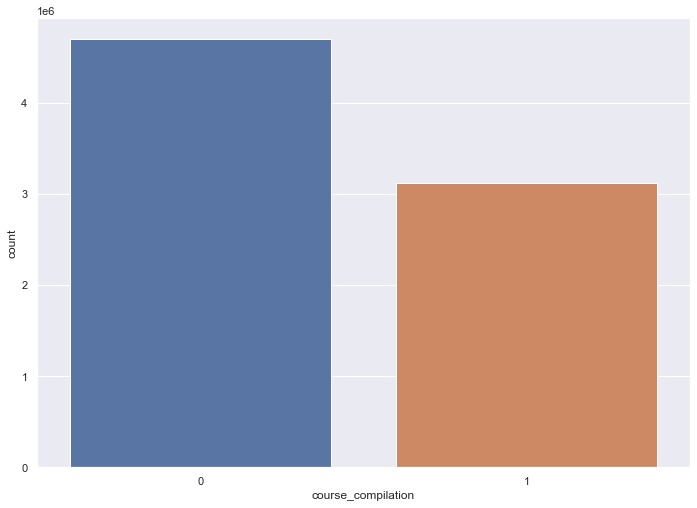

In [26]:
sns.countplot(x=train_dataset.course_compilation)

<AxesSubplot:xlabel='course_compilation', ylabel='count'>

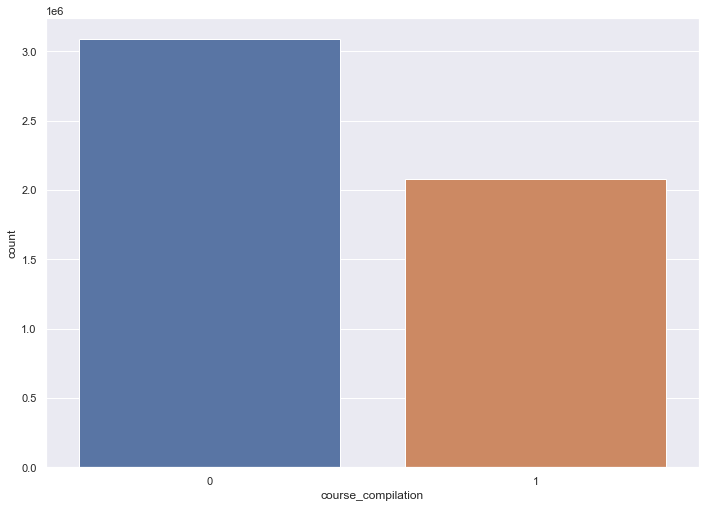

In [27]:
sns.countplot(x=test_dataset.course_compilation)

### Feature engineering on training dataset

In [28]:
train_dataset = pd.get_dummies(train_dataset, columns=['source','event'])

In [29]:
test_dataset = pd.get_dummies(test_dataset, columns=['source','event'])

In [30]:
addition_train_features = train_dataset[['object','username','course_id','time','course_compilation']]

In [31]:
train_dataset = train_dataset.drop(['object','username','course_id','time','course_compilation'], axis=1)

In [32]:
addition_test_features = test_dataset[['object','username','course_id','time','course_compilation']]

In [33]:
test_dataset = test_dataset.drop(['object','username','course_id','time','course_compilation'], axis=1)

## Task 2: Form a course recommendation problem from the given dataset and describe what's the training input and training output of your problem. Prepare data for training and testing. If you use KDDCUP 15 dataset, you still need to describe how they prepare training and test dataset.

Hint: collaborative filtering based approaches may work on this dataset.

We're gonna use KDDCUP-2015 dataset, which includes 39 courses and 120542 enrolled users from the KDD CUP 
2015(KDD CUP 2015 Dataset), demonstrates how to forecast dropouts in online courses.
The proposed architecture for dropout prediction.

We already have training set and testing set so we don't have to do any split.

# TODO textual answer for task 2

<table>
  <thead>
    <tr>
      <th>Features</th>
      <th>Description</th>
    </tr>
   </thead>
   <tbody>
     <tr>
       <td>enrollment_id (INPUT Feature)</td>
       <td>Unique Id of an enrolled user.</td>
     </tr>
     <tr>
     <td>time</td>
     <td>Time of the enrollment</td>
     </tr>
     <tr>
       <td>source (INPUT feature)</td>
       <td>Link to the event (server or browser).</td>
     </tr>
     <tr>
       <td rowspan=8>event (seven different event types) (INPUT Feature)</td>
     </tr>
      <tr>
        <td>Pbm - Practicing academic work</td>
     </tr>
     <tr>
       <td>Video - Listening training sessions</td>
     </tr>
     <tr>
       <td>Access - Accessing the other course materials.</td>
     </tr>
     <tr>
       <td>Wiki - Surf data via the web.</td>
     </tr>
     <tr>
       <td>Discussion - Sharing data on the message boards</td>
     </tr>
     <tr>
       <td>Navigate - Browsing through different areas of the program.</td>
     </tr>
     <tr>
       <td>Page_close – Exit the website</td>
     </tr>
          <td>object</td>
          <td>Module Id</td>
     </tr>
          <td>username</td>
          <td>The username of the participant</td>
     </tr>
        <td>course_id</td>
        <td>The ID of the course that user enrolled in</td>
     </tr>
    <tr>
       <td>Course completion (OUTPUT feauture)</td>
       <td>Course completion (value 1) or dropout (value 0) of a user.</td>
     </tr>
     <tr>
     </tr>
  </tbody>
</table>

The output here based on slides refs that came with datasets.

## Task 3: Build a course recommendation system (you can use any existing recommendation model, deep learning based or non deep learning based) and evaluate the performance of your model on testing data.

In [34]:
clf_lr = LogisticRegression(max_iter=1000000)
clf_lr.fit(train_dataset,addition_train_features['course_compilation'])

LogisticRegression(max_iter=1000000)

In [35]:
predicted_values_lr = clf_lr.predict(test_dataset)

In [36]:
KNN_clf = KNeighborsClassifier(n_neighbors=21)
KNN_clf.fit(train_dataset,addition_train_features['course_compilation'])

KNeighborsClassifier(n_neighbors=21)

In [37]:
predicted_values_KNN = KNN_clf.predict(test_dataset)

## Task 4: Report your findings from the experiments.


### accuracy score using logisitc regression classifier

In [38]:
print(f"The accuracy score is {accuracy_score(addition_test_features['course_compilation'], predicted_values_lr)}")

The accuracy score is 0.6334241123291794


### classification report using logisitic regression classifier

In [39]:
print(classification_report(addition_test_features['course_compilation'], predicted_values_lr))

              precision    recall  f1-score   support

           0       0.66      0.79      0.72   3086957
           1       0.56      0.41      0.47   2076866

    accuracy                           0.63   5163823
   macro avg       0.61      0.60      0.60   5163823
weighted avg       0.62      0.63      0.62   5163823



### accuracy score using linear KNN classifier

In [40]:
print(f"The accuracy score is {accuracy_score(addition_test_features['course_compilation'], predicted_values_KNN)}")

The accuracy score is 0.5535501507313477


### classification report using linear KNN classifier

In [41]:
print(classification_report(addition_test_features['course_compilation'], predicted_values_KNN))

              precision    recall  f1-score   support

           0       0.69      0.47      0.56   3086957
           1       0.46      0.68      0.55   2076866

    accuracy                           0.55   5163823
   macro avg       0.57      0.57      0.55   5163823
weighted avg       0.60      0.55      0.55   5163823



That's becuause we don't have too much informative features in our data set only two informative features that we have are (event and source) so if we want to increase the accuracy we want to add some important features like the duration of that course.

Findings: From above results we see that the logistic regression classifier results is better than KNN classifier, but why we don't able to get high accuracy?